<img src='http://imgur.com/1ZcRyrc.png' style='float: left; margin: 20px; height: 55px'>


# DSI-SG-42 Capstone Project:
### Silent Echoes: From Hand Waves to Written Phrases

# 5. Modeling

In this notebook we still employ the use of Long-Short Term Memory (LSTM) Neural Network to train and predict the sign words (`please`, `sorry`, `hello`).

In [16]:
# import libraries
import time
import os
import random
import datetime
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, accuracy_score, recall_score, f1_score

from keras import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Include a logging file
log_dir = os.path.join('Model_Logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

# set plot theme
plt.style.use('ggplot')

# set display settings
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Set seed
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

Bringing back the list that this model will be training on and to make a predictions. However, we will also need to convert the list into a numpy array to fit the model architecture.

In [2]:
# the first 3 words that we will be modeling upon
label_names = ['please', 'sorry', 'hello']

first_three = np.array(label_names)

num_classes = len(first_three)
print('Total number of classes:', num_classes) 

Total number of classes: 3


In [3]:
print(first_three)

['please' 'sorry' 'hello']


## 5.1 Import numpy array files

In [4]:
# create a dictionary to store integer values for our classes
label_map = {label:num for num, label in enumerate(first_three)}
label_map

{'please': 0, 'sorry': 1, 'hello': 2}

From the numpy array files that was extracted in the previous notebook, we will load the data from npy files and organizing it into lists of videos along with their corresponding labels.

In [5]:
# combine numpy array files and append a the label to each array
def combine_npy_files(keypoints_type: str):
    # initialize lists to store video arrays and corresponding labels
    video_list = []
    label_list = []
    
    # define the data path based on the keypoints type
    DATA_PATH = os.path.join('../data', keypoints_type)

    # loop through the actions
    for action in first_three:  
        # construc the path for the current action
        action_path = os.path.join(DATA_PATH, action)
        
        # Loop through each video folder in the action directory
        for video_folder in os.listdir(action_path):
            video_folder_path = os.path.join(action_path, video_folder)
            class_arrays = []
            
            # check if the path is a directory
            if os.path.isdir(video_folder_path):
                # Get all .npy files and sort them numerically
                npy_files = sorted(os.listdir(video_folder_path), key=lambda x: int(x.split('.')[0]))
                
                # Load each sorted .npy file and append to the class_array
                for npy_file in npy_files:
                    npy_file_path = os.path.join(video_folder_path, npy_file)
                    res = np.load(npy_file_path)
                    class_arrays.append(res)
                    # print(npy_file) # debug

                # append the class arrays to video_list and add corresponding label
                video_list.append(class_arrays)
                label_list.append(label_map[action])  
    # convert video_list and label_list into and array and return
    return np.array(video_list), np.array(label_list)


## 5.2 Build LSTM Model Function 

We will build our model architecture in a function so we will be able to model it in a neatly. Rather than changing all 3 models, we will just need to change the values or hyperparameters in this function.

In [6]:
# create a function to build model
def build_lstm_model(train_features, train_labels, test_features, test_labels,
                     val_features, val_labels, output_size, num_epochs):
    """
    Trains a Long Short-Term Memory (LSTM) model for sequential data classification.

    Args:
        train_features: numpy array of training features (shape: (samples, timesteps, features))
        train_labels: numpy array of training labels (shape: (samples,))
        test_features: numpy array of testing features (shape: (samples, timesteps, features))
        test_labels: numpy array of testing labels (shape: (samples,))
        num_epochs: Number of epochs to train the model
        output_size: Number of output classes (used for output layer size)

    Returns:
        A trained Keras model and a dictionary containing training history.
    """

    # Set seed settings (if applicable)
    set_seed()


    # instantiate sequentialm model
    model = Sequential()

    # Add a LSTM Layer with 64 neurons
    model.add(LSTM(64, return_sequences=False, activation='relu', input_shape=(train_features.shape[1], train_features.shape[2])))
    
    # Add a Dense layer with 64 neurons in the hiddne layer
    model.add(Dense(64, activation='relu'))

    # add a drop out layer to prevent overfitting
    model.add(Dropout(0.5))

    # add a Dense layer output with 'softmax' activation for multi-class classification
    model.add(Dense(output_size, activation='softmax'))

    # define early stopping
    callbacks = [
        EarlyStopping(monitor='val_categorical_accuracy', patience=num_epochs, verbose=1, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    # compile the model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # record start time for training
    start_time = time.time()

    # train the model using train features and labels, include validation data and callbacks
    history = model.fit(train_features, train_labels, epochs=num_epochs,
                            validation_data=(val_features, val_labels),
                            callbacks=callbacks)

    # record end time for training
    end_time = time.time()
    # evaluate the model using test features and labels
    loss, accuracy = model.evaluate(test_features, test_labels)

    # print test loss and accuracy
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    # print the training time
    print(f'Training Time: {end_time - start_time:.2f} seconds')

    # print summary model
    model.summary()

    return model, history  # Return both the trained model and history for further analysis


---
### 5.3 Modeling with LSTM on Comprehensive Model
---


Let us check the total number of samples we have in this dataset. We wil print the shape of the object to inspect the integrity of the file. 

There should be 3 values in the features (predictors) object which would correspond to (`number of samples`, `number of frames in each sample`, `number of landmark values`). 

There will be 1 value in the labels object which would correspond to (`number of samples`,). The value for the first item should be identical in both the features and labels object.

In [7]:
%%time

# function call to combine npy files for train, test, and validation files

# train dataset
train_full_features, train_full_labels = combine_npy_files('training_full_keypoints')

print(f'''
      Shape of train feature set: {train_full_features.shape}
      Shape of train labels set: {train_full_labels.shape}
      
       ''')


      Shape of train feature set: (520, 60, 1662)
      Shape of train labels set: (520,)
      
       
CPU times: total: 18 s
Wall time: 5min 13s


In [8]:
%%time

# test dataset
test_full_features, test_full_labels = combine_npy_files('testing_full_keypoints')

print(f'''
      Shape of train feature set: {test_full_features.shape}
      Shape of train labels set: {test_full_labels.shape}
      
       ''')


      Shape of train feature set: (128, 60, 1662)
      Shape of train labels set: (128,)
      
       
CPU times: total: 3.88 s
Wall time: 1min 17s


In [9]:
%%time

# val dataset
val_full_features, val_full_labels = combine_npy_files('val_full_keypoints')

print(f'''
      Shape of train feature set: {val_full_features.shape}
      Shape of train labels set: {val_full_labels.shape}
      
       ''')


      Shape of train feature set: (144, 60, 1662)
      Shape of train labels set: (144,)
      
       
CPU times: total: 5.59 s
Wall time: 1min 26s


In [10]:
print('Number of classes (first_three) in this model:', first_three.shape)

Number of classes (first_three) in this model: (3,)


Since the features datasets for train, test, and val has been converted into a numpy array appropriately, we will need to convert our classes by using one-hot encoding. We can do so by using the `to_categorical` function from the TensorFlow/Keras package.


In [11]:
# one hot encode labels variable

# train labels
train_full_labels = to_categorical(train_full_labels).astype(int)

# test labels
test_full_labels = to_categorical(test_full_labels).astype(int)

# validation labels
val_full_labels = to_categorical(val_full_labels).astype(int)

In [12]:
# initiate the model training
model_full, history_full = build_lstm_model(train_full_features, train_full_labels, test_full_features, test_full_labels,
                 val_full_features, val_full_labels, first_three.shape[0], 50)

Epoch 1/50
17/17 [==============================] - 4s 127ms/step - loss: 2.3135 - categorical_accuracy: 0.3731 - val_loss: 1.4323 - val_categorical_accuracy: 0.1667
Epoch 2/50
17/17 [==============================] - 2s 99ms/step - loss: 1.4203 - categorical_accuracy: 0.4423 - val_loss: 1.6451 - val_categorical_accuracy: 0.2222
Epoch 3/50
17/17 [==============================] - 2s 99ms/step - loss: 1.4178 - categorical_accuracy: 0.4731 - val_loss: 1.2052 - val_categorical_accuracy: 0.2083
Epoch 4/50
17/17 [==============================] - 2s 106ms/step - loss: 1.0412 - categorical_accuracy: 0.5346 - val_loss: 1.1648 - val_categorical_accuracy: 0.2500
Epoch 5/50
17/17 [==============================] - 2s 108ms/step - loss: 0.9973 - categorical_accuracy: 0.5173 - val_loss: 1.2890 - val_categorical_accuracy: 0.2222
Epoch 6/50
17/17 [==============================] - 2s 99ms/step - loss: 0.9690 - categorical_accuracy: 0.5173 - val_loss: 1.1380 - val_categorical_accuracy: 0.2292
Epoch 7

From the information generated after the completion of the training, we see that the the `comprehensive model` has a test accuracy of 0.6875. The test ran the full 50 epochs with a loss of 1.1245. This model would be decent but may not be robust enough for a good prediction.


#### 5.3.1 Plot the Accuracy and Loss on a Graph

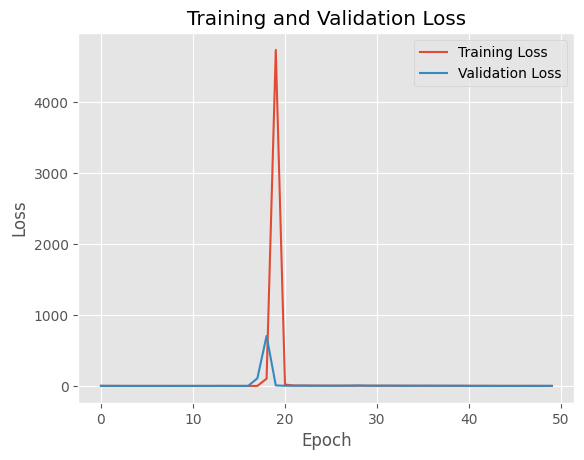

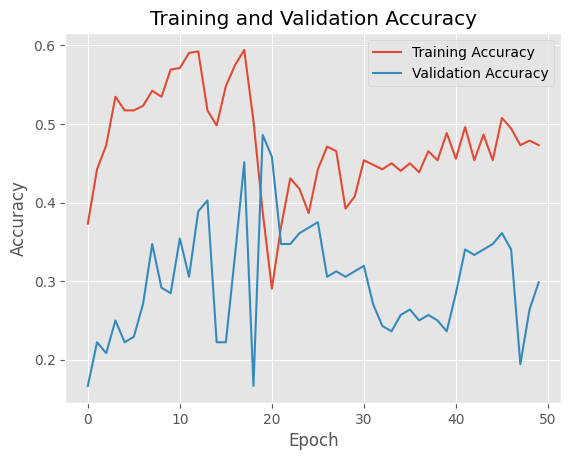

In [14]:
# plot the validation/training loss and accuracy

# Get the loss history from the training
training_loss = history_full.history['loss']
validation_loss = history_full.history['val_loss']


# Plot loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

# add plot info
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the accuracy history from the training
training_accuracy = history_full.history['categorical_accuracy']
validation_accuracy = history_full.history['val_categorical_accuracy']


# Plot accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# add plot info
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In the training loss plot, we observe a sharp spike in both the training and validation line approximately at epoch 18 and 19. This could be due to an unexpected or anomalous sample that was in the test data. 

In the training accuracy plot, we can generally observe that both the training and accuracy values increase in tandem from the start of training to around epoch 19 where the lines intersect and diverge from each other. This is in conjunction with the sudden spike in loss value. From epoch 20, both lines starts to diverge and could indicate that the model is somewhat overfitting. 

#### 5.3.2 Predictions for the Comprehensive Model

We will want to get a classification report and plot a confusion matrix to see how well the model performed.

4/4 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

      please       0.39      0.96      0.55        24
       sorry       0.00      0.00      0.00        16
       hello       0.96      0.74      0.83        88

    accuracy                           0.69       128
   macro avg       0.45      0.57      0.46       128
weighted avg       0.73      0.69      0.68       128



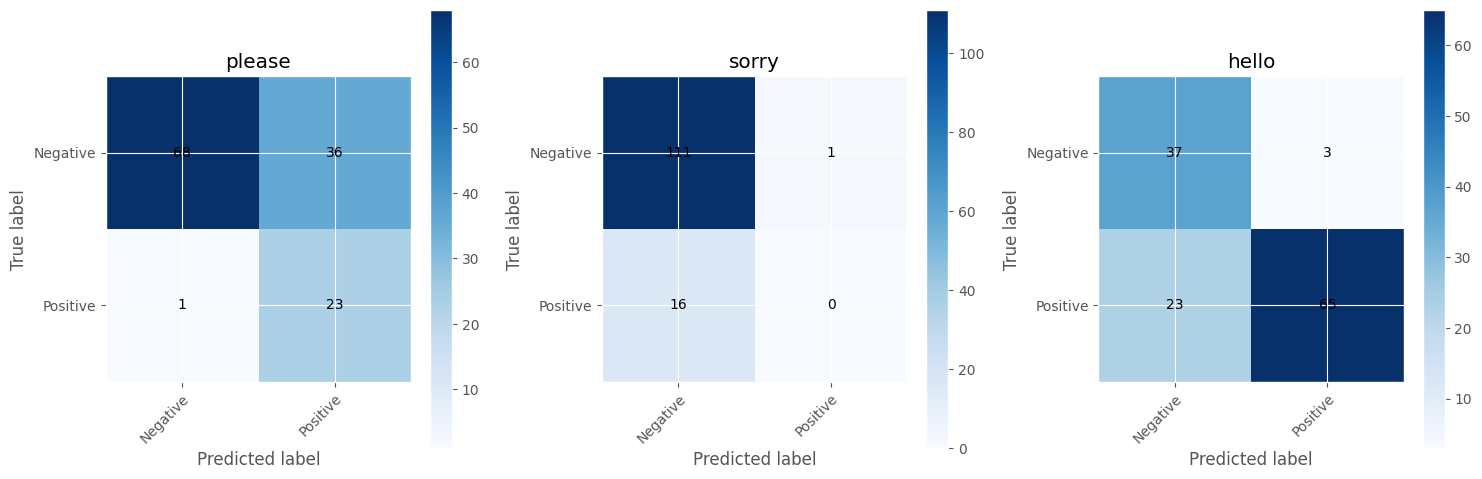

In [20]:
full_predictions = model_full.predict(test_full_features)

#### Classification Report

full_true = np.argmax(test_full_labels, axis=1)
full_pred = np.argmax(full_predictions, axis=1)

# Generate classification report
report = classification_report(full_true, full_pred, target_names=first_three)
print(report)

# obtain the predicted values and the true values
full_true = np.argmax(test_full_labels, axis=1).tolist()
full_pred = np.argmax(full_predictions, axis=1).tolist()

# plot confusion matrix
full_coef_matrices = multilabel_confusion_matrix(full_true, full_pred)

num_labels = len(first_three)

fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(5*num_labels, 5), squeeze=False)
for i in range(num_labels):
    ax = axes.flatten()[i]
    matrix = full_coef_matrices[i]
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Labeling the plot
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], 
           yticklabels=['Negative', 'Positive'],
           title=f'{first_three[i]}',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = matrix.max() 
    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            ax.text(k, j, format(matrix[j, k], 'd'),
                    ha="center", va="center",
                    color="white" if matrix[j, k] > thresh else "black")
fig.tight_layout()
plt.show()




From the classification table, we can see the different metrics for each of the word class. 
- `hello` word class has the best score of 0.83 for f1-score
- `please` word class has the second best score of 0.55 for f1-score
- `sorry` word class performed the worst with a f1-score of 0.

From the confusion matrix, we can see that the model is able to predict the sign 23 times as the actual sign and 66 times as not `please`. On the other hand, `sorry` is unable to predict any of its sign correctly and made 17 wrong predictions. `hello` had the most corect predictions of 65 times and wrongly predicted 26 times. 

In [ ]:
# Save model

model_full.save('../models/model_full_aug.h5')
model_full.save('../models/model_full_aug.keras')

---
### 5.4 Modeling with LSTM on with Pose, Left and Right Hand (PH)
---

Similarly, we will do the exact same process for the model that excludes facial features. 

In [15]:
%%time

# function call to combine npy files for train, test, and validation files

# train dataset
train_ph_features, train_ph_labels = combine_npy_files('training_ph_keypoints')

print(f'''
      Shape of train feature set: {train_ph_features.shape}
      Shape of train labels set: {train_ph_labels.shape}
      
       ''')


      Shape of train feature set: (520, 60, 258)
      Shape of train labels set: (520,)
      
       
CPU times: total: 19.9 s
Wall time: 4min 33s


In [22]:
%%time

# test dataset
test_ph_features, test_ph_labels = combine_npy_files('testing_ph_keypoints')

print(f'''
      Shape of train feature set: {test_ph_features.shape}
      Shape of train labels set: {test_ph_labels.shape}
      
       ''')


      Shape of train feature set: (128, 60, 258)
      Shape of train labels set: (128,)
      
       
CPU times: total: 2.48 s
Wall time: 1min


In [23]:
%%time

# val dataset
val_ph_features, val_ph_labels = combine_npy_files('val_ph_keypoints')

print(f'''
      Shape of train feature set: {val_ph_features.shape}
      Shape of train labels set: {val_ph_labels.shape}
      
       ''')


      Shape of train feature set: (144, 60, 258)
      Shape of train labels set: (144,)
      
       
CPU times: total: 3.25 s
Wall time: 1min 9s


In [24]:
# check the number of classes for this set

print('Number of classes (first_three) in this model:', first_three.shape)

Number of classes (first_three) in this model: (3,)


In [25]:
# one hot encode labels variable

# train labels
train_ph_labels = to_categorical(train_ph_labels).astype(int)

# test labels
test_ph_labels = to_categorical(test_ph_labels).astype(int)

# validation labels
val_ph_labels = to_categorical(val_ph_labels).astype(int)

In [26]:
# initiate training on pose, left+right hand model
model_ph, history_ph = build_lstm_model(train_ph_features, train_ph_labels, test_ph_features, test_ph_labels,
                 val_ph_features, val_ph_labels, first_three.shape[0], 50)



Epoch 1/50
17/17 [==============================] - 2s 45ms/step - loss: 1.0364 - categorical_accuracy: 0.4885 - val_loss: 1.1171 - val_categorical_accuracy: 0.3333
Epoch 2/50
17/17 [==============================] - 0s 26ms/step - loss: 0.9003 - categorical_accuracy: 0.6058 - val_loss: 1.0441 - val_categorical_accuracy: 0.4792
Epoch 3/50
17/17 [==============================] - 0s 26ms/step - loss: 0.8311 - categorical_accuracy: 0.6577 - val_loss: 0.9967 - val_categorical_accuracy: 0.4583
Epoch 4/50
17/17 [==============================] - 0s 26ms/step - loss: 0.9398 - categorical_accuracy: 0.5731 - val_loss: 1.1638 - val_categorical_accuracy: 0.3681
Epoch 5/50
17/17 [==============================] - 0s 27ms/step - loss: 0.7792 - categorical_accuracy: 0.6769 - val_loss: 7.1037 - val_categorical_accuracy: 0.4167
Epoch 6/50
17/17 [==============================] - 0s 29ms/step - loss: 0.9511 - categorical_accuracy: 0.5654 - val_loss: 1.0693 - val_categorical_accuracy: 0.2986
Epoch 7/50

From the information generated after the completion of the training, we see that the the `ph model` (pose and hands) has a test accuracy of 0.1953. The test ran the full 50 epochs with a loss of 26.96. This model has poor accuracy and could not generalize well to the test data.

#### 5.4.1 Plot the Accuracy and Loss on a Graph

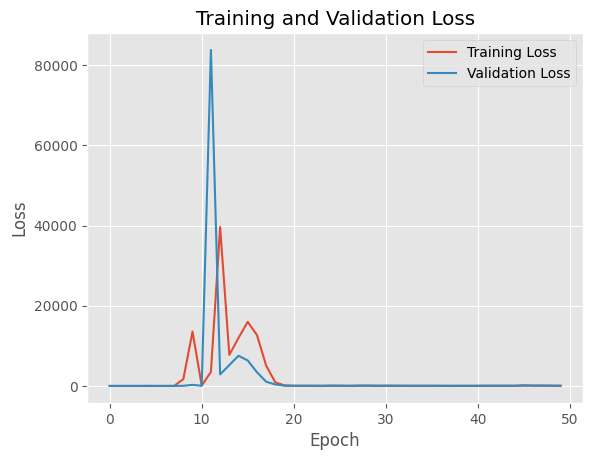

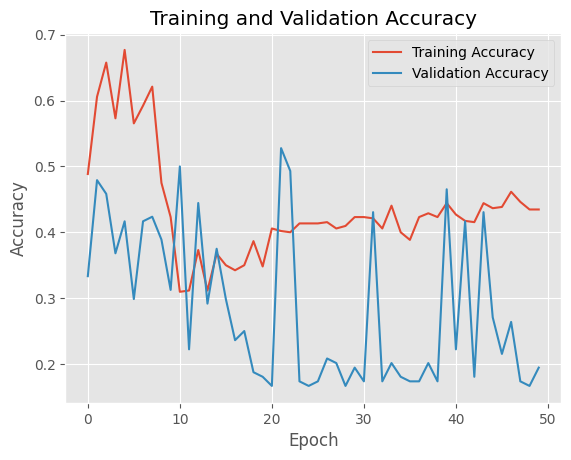

In [27]:
# plot the validation/training loss and accuracy

# Get the loss and accuracy history from the training
training_loss = history_ph.history['loss']
validation_loss = history_ph.history['val_loss']


# Plot loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

# add plot info
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the accuracy history from the training
training_accuracy = history_ph.history['categorical_accuracy']
validation_accuracy = history_ph.history['val_categorical_accuracy']

# Plot accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# add plot info
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In the training loss plot, we observe several high losses in the training line reaching as high as 39635. However, validation loss spiked as high as 83802. This seems to follow a similar pattern to the `comprehensive model` where there was a spike in loss mid-training. 

In the training accuracy plot, we observe that the lines do not follow each other and diverged from epoch 10. There were multiple large spikes in the validation line and several dips in accuracy for the training line. 

This would indicate that the model is not able to generalize well. During keypoints extraction, the OpenCV Feed is open and we can see the landmarks and connection lines superimposed on the signer and there were multiple times when the pose landmark were not captured or that the landmarks were not in the correct place. This might be a possible complication for using pose landmarks.

#### 5.4.2 Predictions for Pose, Left and Right Hands Model

Similarly, we want to get a classification report and plot a confusion matrix

In [28]:
ph_predictions = model_ph.predict(test_ph_features)

4/4 [==============================] - 0s 11ms/step


In [29]:
#### Classification Report

ph_true = np.argmax(test_ph_labels, axis=1)
ph_pred = np.argmax(ph_predictions, axis=1)

# Generate classification report
report = classification_report(ph_true, ph_pred, target_names=first_three)
print(report)

              precision    recall  f1-score   support

      please       0.16      0.75      0.26        24
       sorry       0.00      0.00      0.00        16
       hello       0.50      0.08      0.14        88

    accuracy                           0.20       128
   macro avg       0.22      0.28      0.13       128
weighted avg       0.37      0.20      0.14       128



From the classification report we can see that the f1-score for all word classes are poor. The word class `sorry` still has a value of 0. 

Overall accuracy is only 0.2. This model is not able to predict the word signs.

In [30]:
# obtain the predicted values and the true values
ph_true = np.argmax(test_ph_labels, axis=1).tolist()
ph_pred = np.argmax(ph_predictions, axis=1).tolist()

ph_coef_matrices = multilabel_confusion_matrix(ph_true, ph_pred)

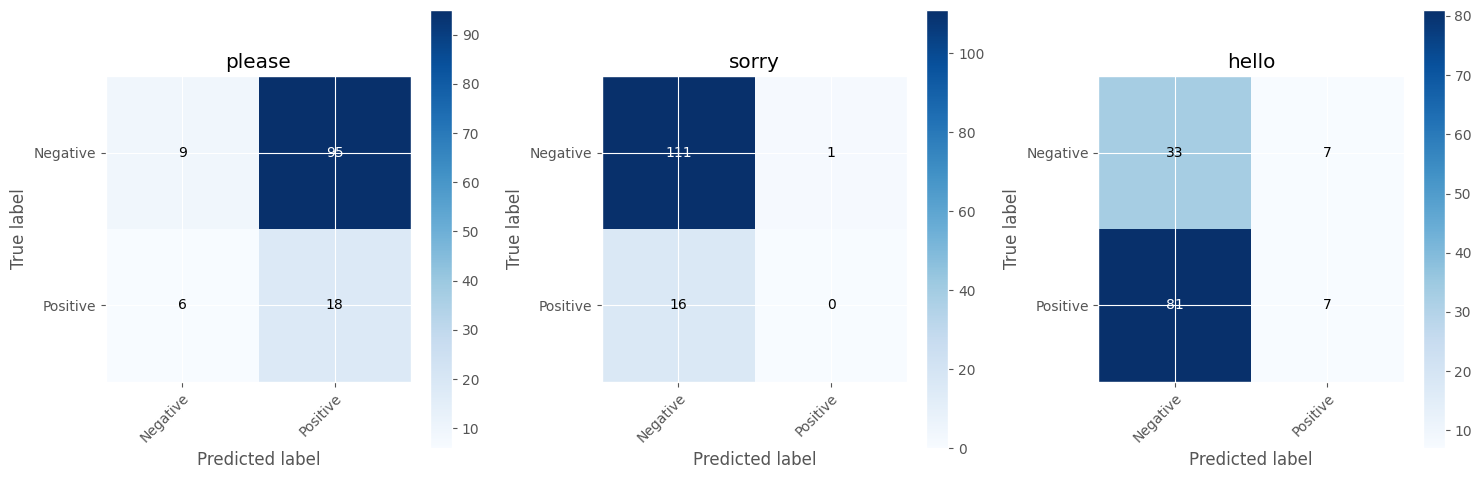

In [31]:
# plot multilabel confustion matrix

num_labels = len(first_three)

fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(5*num_labels, 5), squeeze=False)
for i in range(num_labels):
    ax = axes.flatten()[i]
    matrix = ph_coef_matrices[i]
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Labeling the plot
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], 
           yticklabels=['Negative', 'Positive'],
           title=f'{first_three[i]}',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = matrix.max() / 2.
    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            ax.text(k, j, format(matrix[j, k], 'd'),
                    ha="center", va="center",
                    color="white" if matrix[j, k] > thresh else "black")
fig.tight_layout()
plt.show()


From the confusion matrix, the overall numbers show that this model incorrectly identify most of the test samples wrongly. 

In [73]:
# Save model

model_ph.save('../models/model_ph_aug.h5')
model_ph.save('../models/model_ph_aug.keras')

---
### 5.5 Modeling with LSTM on Basic (hands) Model
---

This will be the final model and will conduct the same method of training

In [32]:
%%time

# function call to combine npy files for train, test, and validation files

# train dataset
train_hands_features, train_hands_labels = combine_npy_files('training_hands_keypoints')

print(f'''
      Shape of train feature set: {train_hands_features.shape}
      Shape of train labels set: {train_hands_labels.shape}
      
       ''')


      Shape of train feature set: (520, 60, 126)
      Shape of train labels set: (520,)
      
       
CPU times: total: 11.1 s
Wall time: 3min 8s


In [33]:
%%time

# test dataset
test_hands_features, test_hands_labels = combine_npy_files('testing_hands_keypoints')

print(f'''
      Shape of train feature set: {test_hands_features.shape}
      Shape of train labels set: {test_hands_labels.shape}
      
       ''')


      Shape of train feature set: (128, 60, 126)
      Shape of train labels set: (128,)
      
       
CPU times: total: 2.73 s
Wall time: 42.7 s


In [34]:
%%time

# val dataset
val_hands_features, val_hands_labels = combine_npy_files('val_hands_keypoints')

print(f'''
      Shape of train feature set: {val_hands_features.shape}
      Shape of train labels set: {val_hands_labels.shape}
      
       ''')


      Shape of train feature set: (144, 60, 126)
      Shape of train labels set: (144,)
      
       
CPU times: total: 3.27 s
Wall time: 53.7 s


In [35]:
# check the number of classes for this set

print('Number of classes (first_three) in this model:', first_three.shape)

Number of classes (first_three) in this model: (3,)


In [36]:
# one hot encode labels variable

# train labels
train_hands_labels = to_categorical(train_hands_labels).astype(int)

# test labels
test_hands_labels = to_categorical(test_hands_labels).astype(int)

# validation labels
val_hands_labels = to_categorical(val_hands_labels).astype(int)

In [37]:
# initiate training on left+right hand model
model_hands, history_hands = build_lstm_model(train_hands_features, train_hands_labels, test_hands_features, test_hands_labels,
                 val_hands_features, val_hands_labels, first_three.shape[0], 50)



Epoch 1/50
17/17 [==============================] - 2s 41ms/step - loss: 0.9805 - categorical_accuracy: 0.4558 - val_loss: 1.1082 - val_categorical_accuracy: 0.3403
Epoch 2/50
17/17 [==============================] - 0s 24ms/step - loss: 0.9409 - categorical_accuracy: 0.5231 - val_loss: 1.1199 - val_categorical_accuracy: 0.3750
Epoch 3/50
17/17 [==============================] - 0s 23ms/step - loss: 0.9140 - categorical_accuracy: 0.5404 - val_loss: 1.2730 - val_categorical_accuracy: 0.2986
Epoch 4/50
17/17 [==============================] - 0s 23ms/step - loss: 0.8583 - categorical_accuracy: 0.5904 - val_loss: 1.1133 - val_categorical_accuracy: 0.4236
Epoch 5/50
17/17 [==============================] - 0s 24ms/step - loss: 0.8705 - categorical_accuracy: 0.5942 - val_loss: 0.9897 - val_categorical_accuracy: 0.4583
Epoch 6/50
17/17 [==============================] - 0s 23ms/step - loss: 0.9045 - categorical_accuracy: 0.5885 - val_loss: 1.1040 - val_categorical_accuracy: 0.3750
Epoch 7/50

From the information generated after the completion of the training, we see that the `hands` model has a test accuracy of 0.8672. The model ran the full 50 epochs with a test loss of 0.468. This is the best performing model so far and might indicate that the model can generalize well with the training data.

#### 5.5.1 Plot the Accuracy and Loss on a Graph

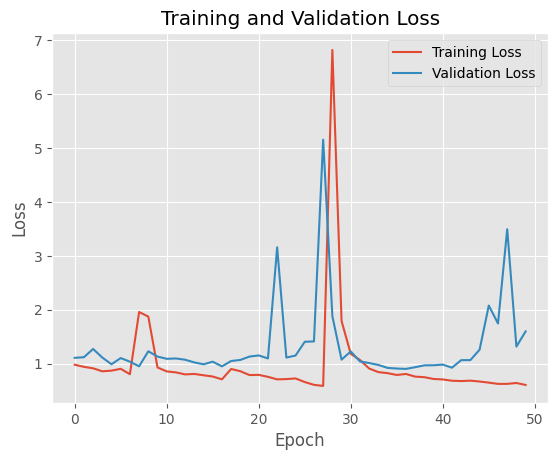

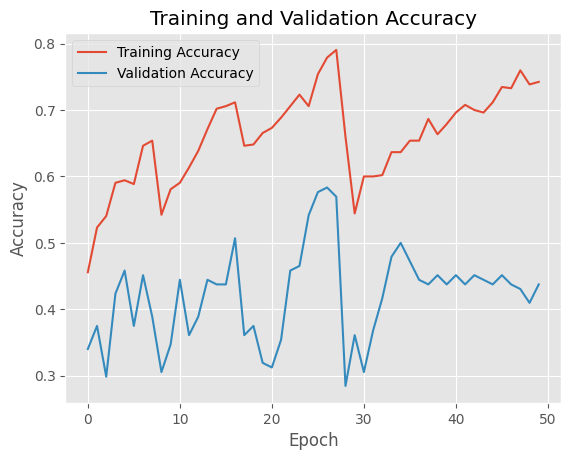

In [38]:
# plot the validation/training loss and accuracy

# Get the loss and accuracy history from the training
training_loss = history_hands.history['loss']
validation_loss = history_hands.history['val_loss']
training_accuracy = history_hands.history['categorical_accuracy']
validation_accuracy = history_hands.history['val_categorical_accuracy']

# Plot loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In the training plot loss, we can observe a large spike at epoch 29 with a loss of 6.8, while the validation loss had multiple spikes at 5.2 at epoch 28. Interestingly, this anomolous spike appear in all models. We can also see that both the training and validation move in tandem with one another which is a good sign.

In the training accuracy plot, we can observe that both training and validation accuracy are moving generally together even the sharp decrease in accuracy at about epoch 29. This trend continues until epoch 33 where both lines start to diverge.

This would suggest that the `Hands` model is able to generalize well with the training data.

#### 5.5.2 Predictions for Hands Model

Similarly, we want to get a classification report and plot a confusion matrix

In [39]:
hands_predictions = model_hands.predict(test_hands_features)

4/4 [==============================] - 0s 10ms/step


In [40]:
#### Classification Report

hands_true = np.argmax(test_hands_labels, axis=1)
hands_pred = np.argmax(hands_predictions, axis=1)

# Generate classification report
report = classification_report(hands_true, hands_pred, target_names=first_three)
print(report)

              precision    recall  f1-score   support

      please       0.71      0.83      0.77        24
       sorry       1.00      0.19      0.32        16
       hello       0.91      1.00      0.95        88

    accuracy                           0.87       128
   macro avg       0.87      0.67      0.68       128
weighted avg       0.88      0.87      0.84       128



From the classification report, we see that there are improvements to the overall scores. Focusing again on the f1-score:

- `hello` had the highest score of 0.95
- `please` had the next highest score of 0.77
- `sorry` finally has a score of 0.32

Overall accuracy for the model is 0.87 and `sorry` seems to be a word class that is difficult for the model to classify

In [41]:
# obtain the predicted values and the true values
hands_true = np.argmax(test_hands_labels, axis=1).tolist()
hands_pred = np.argmax(hands_predictions, axis=1).tolist()

In [42]:
# plot multilabel confustion matrix
hands_coef_matrices = multilabel_confusion_matrix(hands_true, hands_pred)

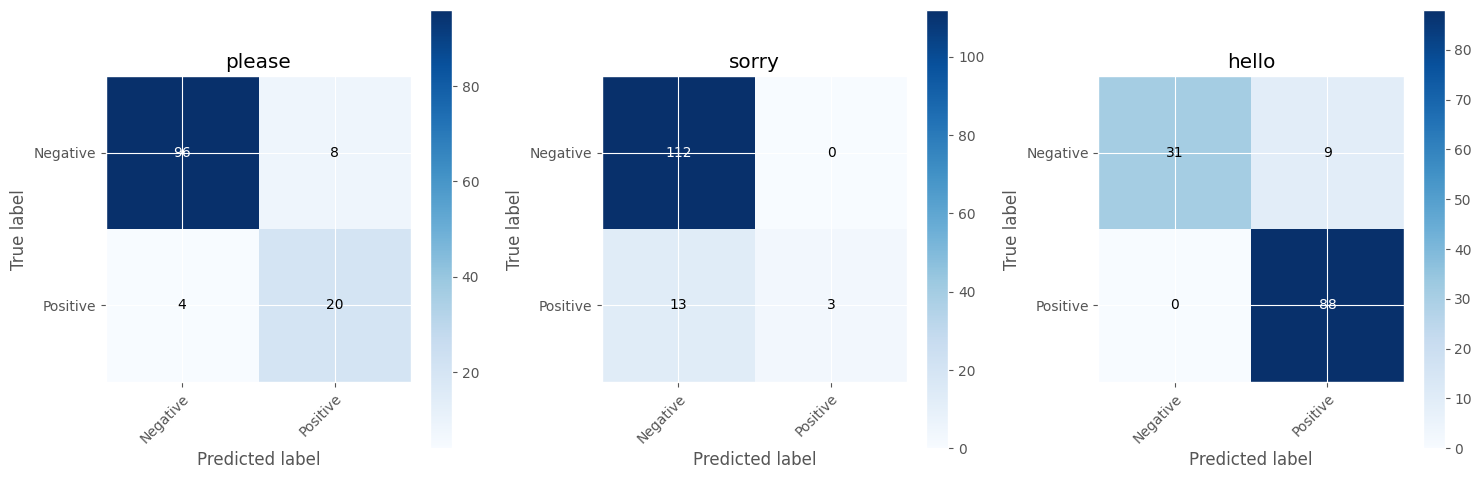

In [43]:
num_labels = len(first_three)

fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(5*num_labels, 5), squeeze=False)
for i in range(num_labels):
    ax = axes.flatten()[i]
    matrix = hands_coef_matrices[i]
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Labeling the plot
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], 
           yticklabels=['Negative', 'Positive'],
           title=f'{first_three[i]}',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = matrix.max() / 2.
    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            ax.text(k, j, format(matrix[j, k], 'd'),
                    ha="center", va="center",
                    color="white" if matrix[j, k] > thresh else "black")
fig.tight_layout()
plt.show()


From the confusion matrix, we can see that `please` word class has been classified correctly 20 times with an error of 12 samples. The word class `sorry` has been predicted wrong 13 times but is correctly classified 3 times. Lastly, `hello` has been correctly classified 88 times with an error of 9 samples.


Evaluating the results from all the models, it seems that the word class that are similar to each other posed the most difficulty for the model. Even though after cropping and resizing, the number of samples for `sorry` has only 18 samples, while `please` had 30. The most samples is found in word class `hello` with 17 samples and was the most disimilar among the 3 classes with its open palms in the air, being able to capture all the landmarks easily. The only difference between `please` and `sorry` was the open palms (`please`) and clenched fist (`sorry`). 

In [70]:
# Save model

model_hands.save('../models/model_hands_aug.h5')
model_hands.save('../models/model_hands_aug.keras')

c:\Users\Tim\GeneralAssembly\Sign_Translator\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
